In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
# Define paths
train_folder = "../dataset/logos_train"
test_folder = "../dataset/logos_test"

# Check if dataset directories exist
if not os.path.exists(train_folder) or not os.path.exists(test_folder):
    raise FileNotFoundError("Train or test directory not found. Please verify the path.")

In [4]:
# SIFT feature extractor
sift = cv2.SIFT_create(
    nfeatures=500,    # Increase number of keypoints
    contrastThreshold=0.02,  # Lower threshold for detecting weaker features
    edgeThreshold=15,  # Higher value to ignore edge-like features
    sigma=1.2  # Adjust Gaussian filter
)


# Image preprocessing parameters
image_size = (1024, 1024)  # Increase image resolution
batch_size = 64  # Number of images processed per batch

# Function to extract SIFT features
def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, image_size)  # Resize image
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Function to process images in batches
def process_images_in_batches(image_paths):
    features = {}
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        for img_path in batch:
            descriptors = extract_sift_features(img_path)
            if descriptors is not None:
                features[img_path] = descriptors
    return features

# Collecting descriptors for training images
train_images = [os.path.join(train_folder, img) for img in os.listdir(train_folder)]
train_features = process_images_in_batches(train_images)

# Convert features to a consistent format (averaging descriptors per image)
X_train = np.array([np.mean(desc, axis=0) for desc in train_features.values() if desc is not None])


In [5]:
# Determine optimal clusters using Silhouette Score
cluster_range = range(2, 21)
silhouette_scores = []

for k in cluster_range:
    gmm = GaussianMixture(n_components=k, random_state=42, init_params='kmeans', max_iter=500, tol=0.1, covariance_type='full', reg_covar=0.01)
    labels = gmm.fit_predict(X_train)
    silhouette_scores.append(silhouette_score(X_train, labels))

# Find optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]


In [6]:
# Train GMM with optimal clusters
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42, init_params='kmeans', max_iter=500, tol=0.1, covariance_type='full', reg_covar=0.0001)
gmm.fit(X_train)

# Collecting descriptors for test images
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder)]
test_features = process_images_in_batches(test_images)

# Convert test features to a consistent format
X_test = np.array([np.mean(desc, axis=0) for desc in test_features.values() if desc is not None])

# Predict clusters for test images
test_labels = gmm.predict(X_test)

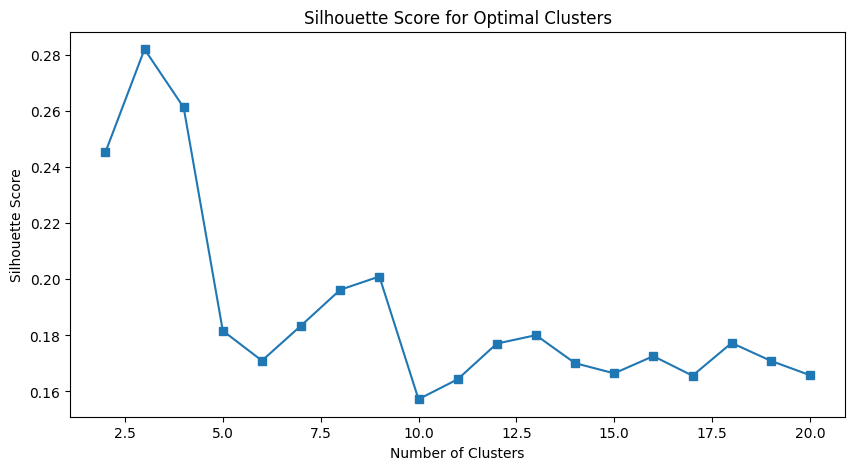

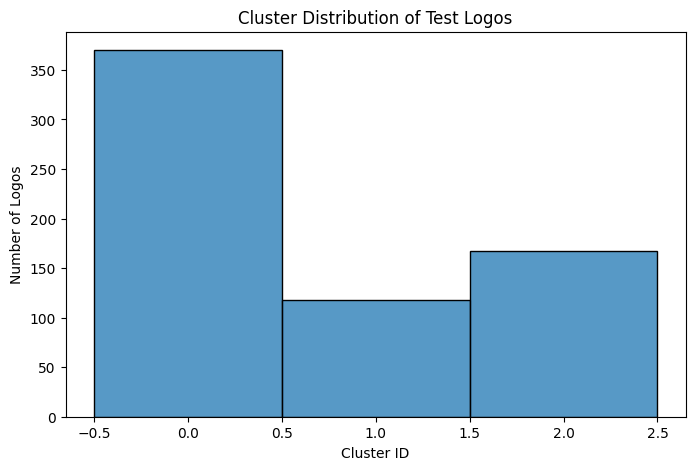

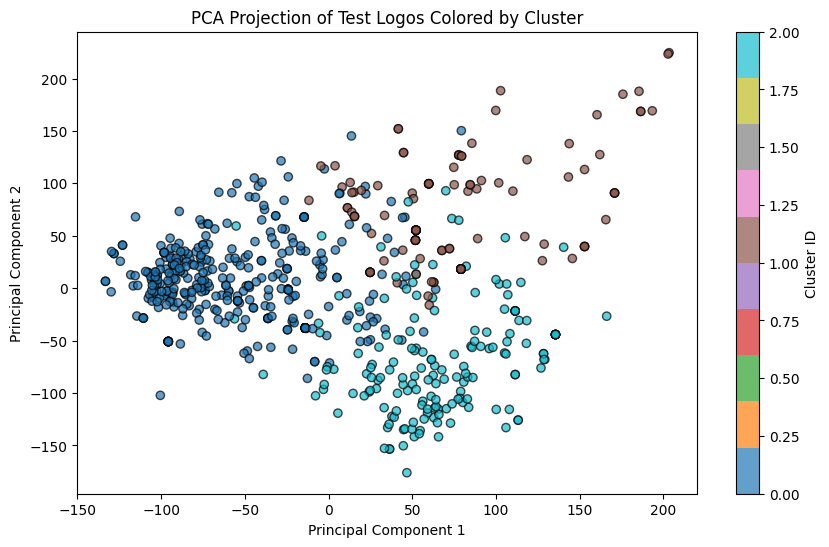

Optimal Number of Clusters: 3
Silhouette Score: 0.28214725852012634


In [7]:
# Plot Silhouette Score to find optimal clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

# Cluster Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(test_labels, bins=optimal_clusters, kde=False, discrete=True)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Logos")
plt.title("Cluster Distribution of Test Logos")
plt.show()

# PCA Projection for 2D visualization on test set
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(label="Cluster ID")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Test Logos Colored by Cluster")
plt.show()

# Print silhouette score
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Silhouette Score: {silhouette_scores[optimal_clusters-2]}")